# Satellite Image Classification

# GPU Being Used:

In [3]:
!nvidia-smi

Wed Oct 23 12:39:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data Pre-processing:

In [4]:
import pandas as pd
import os

# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes
labels = {'/kaggle/input/satellite-image-classification/data/cloudy' : 'Cloudy',
          '/kaggle/input/satellite-image-classification/data/desert' : 'Desert',
          '/kaggle/input/satellite-image-classification/data/green_area' : 'Green_Area',
          '/kaggle/input/satellite-image-classification/data/water' : 'Water',
           }

In [5]:
# Loop over the train, test, and val folders and extract the image path and label
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)

In [6]:
# Save the data to a CSV file
data.to_csv('image_dataset.csv', index=False)

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
# Load the dataset
df = pd.read_csv("/kaggle/working/image_dataset.csv")

In [9]:
df

,image_path,label
0,/kaggle/input/satellite-image-classification/d...,Cloudy
1,/kaggle/input/satellite-image-classification/d...,Cloudy
2,/kaggle/input/satellite-image-classification/d...,Cloudy
3,/kaggle/input/satellite-image-classification/d...,Cloudy
4,/kaggle/input/satellite-image-classification/d...,Cloudy
...,...,...
5626,/kaggle/input/satellite-image-classification/d...,Water
5627,/kaggle/input/satellite-image-classification/d...,Water
5628,/kaggle/input/satellite-image-classification/d...,Water
5629,/kaggle/input/satellite-image-classification/d...,Water


In [10]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# Pre-process the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,                                  zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")


Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


# Deep Learning Model

In [12]:
# Build a deep learning model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
141/141 [==============================] - 101s 641ms/step - loss: 0.5984 - accuracy: 0.7218 - val_loss: 0.5657 - val_accuracy: 0.7657
Epoch 2/5
141/141 [==============================] - 66s 468ms/step - loss: 0.4638 - accuracy: 0.8071 - val_loss: 0.3389 - val_accuracy: 0.8634
Epoch 3/5
141/141 [==============================] - 65s 464ms/step - loss: 0.4011 - accuracy: 0.8337 - val_loss: 0.3862 - val_accuracy: 0.8261
Epoch 4/5
141/141 [==============================] - 66s 467ms/step - loss: 0.3520 - accuracy: 0.8655 - val_loss: 0.3104 - val_accuracy: 0.8749
Epoch 5/5
141/141 [==============================] - 67s 472ms/step - loss: 0.3152 - accuracy: 0.8772 - val_loss: 0.2927 - val_accuracy: 0.8731


In [15]:
num_samples = test_df.shape[0]
num_samples

1127

In [16]:
score = model.evaluate(test_generator,
                       steps=num_samples//32+1,
                       )

36/36 [==============================] - 3s 78ms/step - loss: 0.2927 - accuracy: 0.8731


In [17]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x797b43a33ad0>>

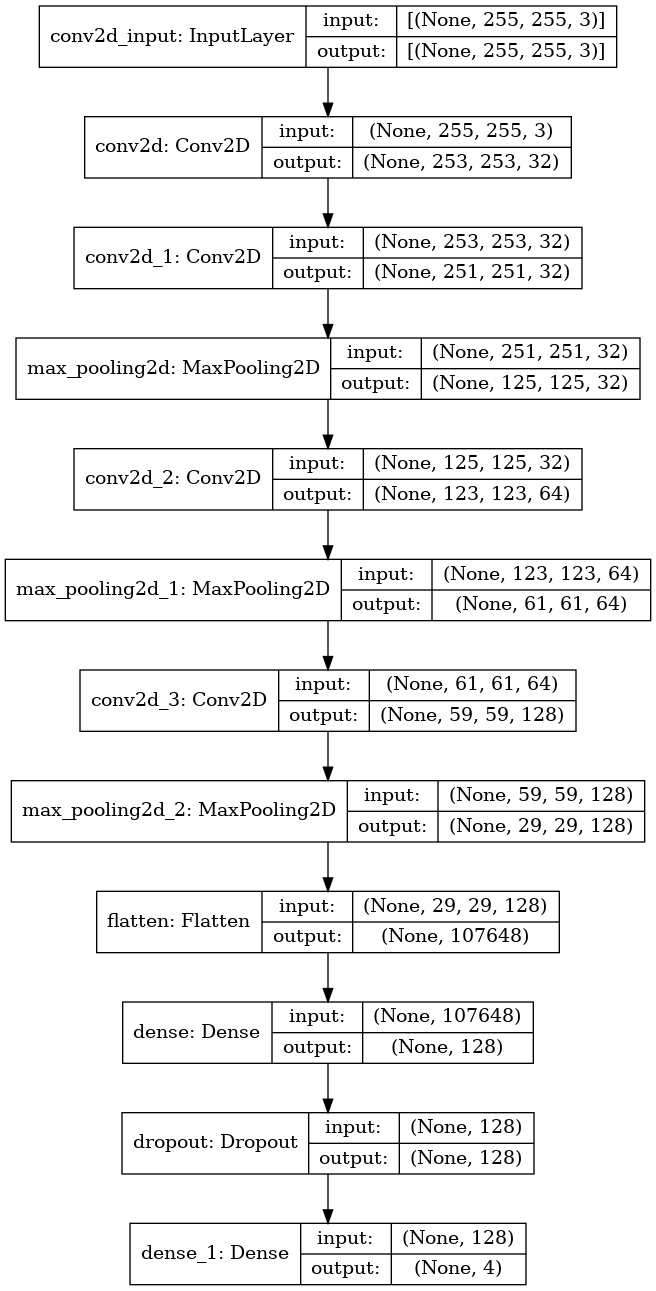

In [18]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

# Loss & Accuracy Visualizations

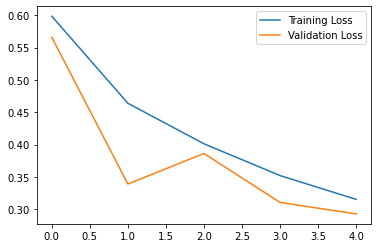

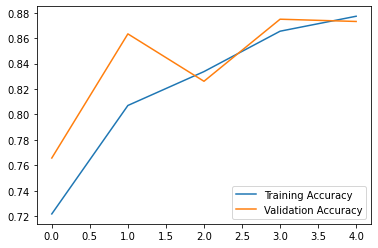

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Saving Our Model

In [20]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('Model.h5')

In [21]:
# Load the model
model = load_model("Model.h5")

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [23]:
# Load an image from the test set
img = load_img("/kaggle/input/satellite-image-classification/data/green_area/Forest_1768.jpg", target_size=(255, 255))

In [24]:
# Convert the image to an array
img_array = img_to_array(img)
img_array

array([[[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       [[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       [[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       ...,

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]]

In [25]:
img_array.shape

(255, 255, 3)

In [26]:
# Normalize the image pixel values to the range [0, 1]
img_array = img_array / 255.0
img_array

array([[[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       [[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       [[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       ...,

       [[0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0

In [27]:
import numpy as np
img_array = np.reshape(img_array, (1, 255, 255, 3))

# Using Our Model For Predictions

In [28]:
# Get the model predictions
predictions = model.predict(img_array)

In [29]:
# Get the class index with the highest predicted probability
class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_label = class_names[class_index]

print("The image is predicted to be '{}'.".format(predicted_label))

The image is predicted to be 'Green_Area'.


In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [48]:
predictions = model.predict(test_generator)

In [49]:
predictions

array([[1.26154264e-02, 2.72054313e-04, 4.02215093e-01, 5.84897459e-01],
       [2.16548786e-01, 1.54696265e-02, 2.80963719e-01, 4.87017930e-01],
       [3.70367919e-03, 4.62215721e-05, 4.21294749e-01, 5.74955404e-01],
       ...,
       [1.68201253e-02, 4.04837920e-04, 3.94961268e-01, 5.87813795e-01],
       [6.97517812e-01, 2.44506761e-01, 1.79816056e-02, 3.99938151e-02],
       [4.75611445e-03, 6.75127812e-05, 4.17910933e-01, 5.77265441e-01]],
      dtype=float32)

In [52]:
true_labels = test_generator.classes

In [53]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([3, 3, 3, ..., 3, 0, 3])

In [54]:
cm = confusion_matrix(true_labels, predicted_labels)

In [55]:
print(cm)

[[104  61   0 163]
 [ 78  48   0 101]
 [ 70  43   0 171]
 [101  47   0 140]]


In [56]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


In [57]:
# Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the classification report for detailed metrics
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))


Accuracy: 0.259094942324756
Precision: 0.19654841959287622
Recall: 0.259094942324756
F1 Score: 0.21719476303858037

Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.29      0.32      0.31       328
      Desert       0.24      0.21      0.23       227
  Green_Area       0.00      0.00      0.00       284
       Water       0.24      0.49      0.32       288

    accuracy                           0.26      1127
   macro avg       0.19      0.25      0.21      1127
weighted avg       0.20      0.26      0.22      1127



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 

In [ ]:
import pandas as pd

# Assuming you have two sets of metrics: metrics_model1 and metrics_model2
metrics_model1 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_model1, precision_model1, recall_model1, f1_model1]
}

metrics_model2 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_model2, precision_model2, recall_model2, f1_model2]
}

# Create a DataFrame to hold the metrics for comparison
comparison_df = pd.DataFrame({
    'Metric': metrics_model1['Metric'],
    'Model 1': metrics_model1['Value'],
    'Model 2': metrics_model2['Value']
})

# Print the comparison table
print(comparison_df)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Confusion matrix


# Plot the confusion matrix as an image
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add the class labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values to the plot
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Advanced Predictions From URLs

In [ ]:
from io import BytesIO
import requests
from tensorflow.keras.preprocessing import image
import numpy as np
import tempfile

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
           ]


for url in url_list:
    response = requests.get(url)
    with tempfile.NamedTemporaryFile(mode='wb') as f:
        f.write(response.content)
        f.seek(0)
        img = image.load_img(f.name, target_size=(255, 255))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)

        classes = model.predict(img, batch_size=10)
        class_index = np.argmax(classes[0])
        predicted_label = class_names[class_index]
        print(url + "The image is predicted to be '{}'.".format(predicted_label))


# **ResNet50 Implementation**

In [62]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = len(class_names)  # Get the number of classes from the class_names list
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model with a unique name
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()

# Use ImageDataGenerator to load and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical'
)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model again with a lower learning rate
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with callbacks
history = resnet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the model
resnet_model.save("resnet50_satellite.h5")

# Evaluation of the model
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Get the predictions
test_generator.reset()  # Reset the generator for evaluation
predictions = resnet_model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Generate the classification report
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 261, 261, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


36/36 [==============================] - 6s 132ms/step
              precision    recall  f1-score   support

      Cloudy       0.28      0.35      0.31       328
      Desert       0.20      0.13      0.16       227
  Green_Area       0.20      0.01      0.02       284
       Water       0.22      0.44      0.30       288

    accuracy                           0.24      1127
   macro avg       0.23      0.23      0.20      1127
weighted avg       0.23      0.24      0.20      1127



In [1]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class indices
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report for detailed metrics
class_names = list(test_generator.class_indices.keys())  # Get class names
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'model' is not defined

# GradCAM and LIME Implementation for CA3

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# Load your trained CNN model
cnn_model = load_model('/kaggle/working/Model.h5')

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the model's predictions
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the top predicted class with respect to the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Compute the mean intensity of the gradients across all filters
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by "how important this channel is" with regard to the top predicted class
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to remove negative values and normalize between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

# Specify the last convolutional layer name
last_conv_layer_name = 'conv2d_3'

# Load the test image from your dataset path
img_path = '/kaggle/input/satellite-image-classification/data/desert/desert(101) (1).jpg'

# Load an image and convert it to an array
img = image.load_img(img_path, target_size=(255, 255))  # Use the correct target size as per your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate heatmap using Grad-CAM for the model's last convolutional layer
heatmap = make_gradcam_heatmap(img_array, cnn_model, last_conv_layer_name)

# Visualize the heatmap
plt.matshow(heatmap)
plt.show()

# Overlay the heatmap on the original image
def overlay_heatmap(heatmap, img_path, alpha=0.4, cmap='jet'):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap(cmap)
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    overlayed_image = jet_heatmap * alpha + img
    overlayed_image = image.array_to_img(overlayed_image)

    plt.imshow(overlayed_image)
    plt.show()
    
# Function to display the original, heatmap, and overlay images side by side
def display_images(img_path, heatmap, alpha=0.6, cmap='jet'):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Display original image
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image.array_to_img(img))
    plt.title('Original Image')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.matshow(heatmap, fignum=False, cmap=cmap)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    # Overlayed image
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap(cmap)
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    overlayed_image = jet_heatmap * alpha + img
    overlayed_image = image.array_to_img(overlayed_image)
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title('Overlayed Heatmap')
    plt.axis('off')

    plt.show()

# Add color bar to the heatmap
def show_heatmap_with_colorbar(heatmap, cmap='jet'):
    plt.matshow(heatmap, cmap=cmap)
    plt.colorbar()  # Add color bar to understand heatmap intensity
    plt.title('Grad-CAM Heatmap with Colorbar')
    plt.axis('off')
    plt.show()

# Show heatmap with colorbar for intensity understanding
show_heatmap_with_colorbar(heatmap)
    

# Display all images (original, heatmap, and overlay)
display_images(img_path, heatmap)


# Apply Grad-CAM and display the overlayed heatmap
overlay_heatmap(heatmap, img_path)


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for a test image
explanation = explainer.explain_instance(img_array[0].astype('double'), 
                                         model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

# Get image and mask for the top predicted label
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

# Display the LIME explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()
